In [3]:
# coding: utf-8
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from functools import partial
from keras.utils.np_utils import to_categorical
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
mnist = input_data.read_data_sets("../MNIST_data/")

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]
y_train1 = to_categorical(y_train1, num_classes=5)
y_valid1 = to_categorical(y_valid1, num_classes=5)
y_test1 = to_categorical(y_test1, num_classes=5)

In [6]:
def init_input():
    with tf.name_scope('input'):
        X = tf.placeholder('float', [None, 784], name='input_x')
        y = tf.placeholder('float', [None, 5], name='label_y')
    return X, y

In [7]:
def add_layer(input_dim, output_dim, inputs, name, keep_prob, activation_function=None):
    name_W = 'W_' + name
    name_b = 'b_' + name
    
    with tf.name_scope(name):
        with tf.name_scope('weight'):
            W = tf.get_variable(shape=[input_dim, output_dim], initializer=tf.contrib.keras.initializers.he_normal(), name=name_W)
            tf.summary.histogram(name + '/weight', W)
        with tf.name_scope('bias'):
            b = tf.Variable(tf.constant(0.1, shape=[1, output_dim]), name=name_b)
            tf.summary.histogram(name + '/bias', b)
        with tf.name_scope('Wx_plus_b'):
            Wx_plus_b = tf.add(tf.matmul(inputs, W), b)
            Wx_plus_b = tf.nn.dropout(Wx_plus_b, keep_prob)
        if activation_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b)
        tf.summary.histogram(name + '/output', outputs)
        return outputs

In [8]:
def build_network(X, n, activation, keep_prob, batch_normalization=False):
    h1 = add_layer(input_dim=784, output_dim=n, inputs=X, name='hidden_layer_1', keep_prob=keep_prob, activation_function=activation)
    if batch_normalization:
        h1 = tf.layers.batch_normalization(h1)
        
    h2 = add_layer(input_dim=n, output_dim=n, inputs=h1, name='hidden_layer_2', keep_prob=keep_prob, activation_function=activation)
    if batch_normalization:
        h2 = tf.contrib.layers.batch_norm(h2, center=True, scale=True, is_training=True)
        
    h3 = add_layer(input_dim=n, output_dim=n, inputs=h2, name='hidden_layer_3', keep_prob=keep_prob, activation_function=activation)
    if batch_normalization:
        h3 = tf.contrib.layers.batch_norm(h3, center=True, scale=True, is_training=True)

    h4 = add_layer(input_dim=n, output_dim=n, inputs=h3, name='hidden_layer_4', keep_prob=keep_prob, activation_function=activation)
    if batch_normalization:
        h4 = tf.contrib.layers.batch_norm(h4, center=True, scale=True, is_training=True)

    h5 = add_layer(input_dim=n, output_dim=n, inputs=h4, name='hidden_layer_5', keep_prob=keep_prob, activation_function=activation)
    if batch_normalization:
        h5 = tf.contrib.layers.batch_norm(h5, center=True, scale=True, is_training=True)
        
    y_hat = add_layer(input_dim=n, output_dim=5, inputs=h5, name='output_layer', keep_prob=keep_prob, activation_function=tf.nn.softmax)
    return y_hat

In [9]:
def init_evaluation(y, y_hat, learning_rate):
    with tf.name_scope('cross_entropy'):
        loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_hat), name='cross_entropy')
    tf.summary.scalar('cross_entropy', loss_function)

    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate, name='train').minimize(loss_function)

    with tf.name_scope('accuracy'):
        correct_prediction_count = tf.equal(tf.argmax(y, 1), tf.argmax(y_hat, 1), name='correction_prediction')
        acc = tf.reduce_mean(tf.cast(correct_prediction_count, 'float'), name='accuracy')
    tf.summary.scalar('accuracy', acc)
    
    return loss_function, optimizer, acc

In [10]:
def DNN(epoch, n_neurons, learning_rate, activation, batch_size, early_stopping, keep_prob=1.0, batch_normalization=False, restore_model_name=None):
    tf.reset_default_graph()
    
    training_id = '[n_neurons_%d, learning_rate_%.4f, activation_%s, batch_size_%d, keep_prob_%s]' % (n_neurons, learning_rate, activation, batch_size, keep_prob)
    print(training_id)
    training_id += "-" + datetime.utcnow().strftime("%Y%m%d%H%M%S")
    logdir = "tf_logs/{}/".format(training_id)
    
    X, y = init_input()
    y_hat = build_network(X, n_neurons, activation, keep_prob, batch_normalization=batch_normalization)
    loss_function, optimizer, acc = init_evaluation(y, y_hat, learning_rate)
    
    batch = int(mnist.train.num_examples / batch_size)

    vali_loss_list = []
    vali_acc_list = []
    train_acc_list = []
    n = 0
    
    saver = tf.train.Saver()
    start_epoch = 0
    
    with tf.Session() as sess:
        if restore_model_name:
            saver.restore(sess, "regular_train/" + restore_model_name)
            start_epoch = int(restore_model_name.split('.')[0].split('_')[-1])
        else:
            sess.run(tf.global_variables_initializer())
            
        merged = tf.summary.merge_all()    
        writer = tf.summary.FileWriter(logdir, sess.graph)
        
        for i in range(start_epoch, epoch):
            for j in range(batch):
                batch_x = X_train1[j * batch_size : (j + 1) * batch_size]
                batch_y = y_train1[j * batch_size : (j + 1) * batch_size]
                sess.run(optimizer, feed_dict={X: batch_x, y: batch_y})
                
            result = sess.run(merged, feed_dict={X: X_valid1, y: y_valid1})
            writer.add_summary(result, i + 1)

            vali_loss = sess.run(loss_function, feed_dict={X: X_valid1, y: y_valid1})
            vali_acc = sess.run(acc, feed_dict={X: X_valid1, y: y_valid1})
            train_acc = sess.run(acc, feed_dict={X: X_train1, y:y_train1})
            
            vali_loss_list.append(vali_loss)
            vali_acc_list.append(vali_acc)
            train_acc_list.append(train_acc)
            
            file_name = 'regular_training_epoch_%d.ckpt' % (i+1)
            save_path = saver.save(sess, "regular_train/%s/%s" % (training_id, file_name))
            best_vali_acc = max(vali_acc_list)
            best_vali_loss = min(vali_loss_list)
            
            print("Epoch: %2d, Train acc: %.4f, Validation acc: %.4f" % (i+1, train_acc, vali_acc))    
            n = n + 1 if vali_acc < best_vali_acc else 0
                
            if n > early_stopping:
                print('Early Stopping at epoch %d' % (i + 1))
                break
        
        file_name = 'final_model'
        save_path = saver.save(sess, "regular_train/%s/%s" %(training_id, file_name))
        print("Model saved in path: %s" % save_path)
        
        train_acc = sess.run(acc, feed_dict={X: X_train1, y:y_train1})
        test_acc = sess.run(acc, feed_dict={X: X_test1, y: y_test1})
        print("Final: Train acc: %.4f, Test acc: %.4f, Difference: %.4f" % (train_acc, test_acc, train_acc - test_acc))
        return train_acc_list, vali_acc_list

In [11]:
def show_train_history(train_acc, vali_acc, keep_prob):
    plt.plot(train_acc)
    plt.plot(vali_acc)
    plt.title('Train history, keep_prob=%.3f' % keep_prob)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [12]:
t1, v1 = DNN(epoch=100, n_neurons=100, learning_rate=0.1, activation=tf.nn.relu, batch_size=100, early_stopping=10, keep_prob=1.00, batch_normalization=True)

[n_neurons_100, learning_rate_0.1000, activation_<function relu at 0x10f19e6a8>, batch_size_100, keep_prob_1.0]
Epoch:  1, Train acc: 0.9790, Validation acc: 0.9793
Epoch:  2, Train acc: 0.9857, Validation acc: 0.9828
Epoch:  3, Train acc: 0.9886, Validation acc: 0.9840
Epoch:  4, Train acc: 0.9908, Validation acc: 0.9867
Epoch:  5, Train acc: 0.9922, Validation acc: 0.9875
Epoch:  6, Train acc: 0.9929, Validation acc: 0.9871
Epoch:  7, Train acc: 0.9941, Validation acc: 0.9883
Epoch:  8, Train acc: 0.9948, Validation acc: 0.9887
Epoch:  9, Train acc: 0.9950, Validation acc: 0.9891
Epoch: 10, Train acc: 0.9954, Validation acc: 0.9871
Epoch: 11, Train acc: 0.9956, Validation acc: 0.9863
Epoch: 12, Train acc: 0.9958, Validation acc: 0.9871
Epoch: 13, Train acc: 0.9959, Validation acc: 0.9875
Epoch: 14, Train acc: 0.9960, Validation acc: 0.9875
Epoch: 15, Train acc: 0.9961, Validation acc: 0.9875
Epoch: 16, Train acc: 0.9963, Validation acc: 0.9871
Epoch: 17, Train acc: 0.9963, Validation

In [15]:
t2, v2 = DNN(epoch=100, n_neurons=100, learning_rate=0.1, activation=tf.nn.relu, batch_size=100, early_stopping=10, keep_prob=0.95, batch_normalization=True)

[n_neurons_100, learning_rate_0.1000, activation_<function relu at 0x10f19e6a8>, batch_size_100, keep_prob_0.9]
Epoch:  1, Train acc: 0.9261, Validation acc: 0.9230
Epoch:  2, Train acc: 0.9456, Validation acc: 0.9425
Epoch:  3, Train acc: 0.9535, Validation acc: 0.9535
Epoch:  4, Train acc: 0.9607, Validation acc: 0.9601
Epoch:  5, Train acc: 0.9614, Validation acc: 0.9597
Epoch:  6, Train acc: 0.9635, Validation acc: 0.9660
Epoch:  7, Train acc: 0.9659, Validation acc: 0.9527
Epoch:  8, Train acc: 0.9660, Validation acc: 0.9644
Epoch:  9, Train acc: 0.9684, Validation acc: 0.9672
Epoch: 10, Train acc: 0.9675, Validation acc: 0.9629
Epoch: 11, Train acc: 0.9709, Validation acc: 0.9660
Epoch: 12, Train acc: 0.9717, Validation acc: 0.9691
Epoch: 13, Train acc: 0.9716, Validation acc: 0.9707
Epoch: 14, Train acc: 0.9715, Validation acc: 0.9699
Epoch: 15, Train acc: 0.9702, Validation acc: 0.9687
Epoch: 16, Train acc: 0.9729, Validation acc: 0.9664
Epoch: 17, Train acc: 0.9723, Validation

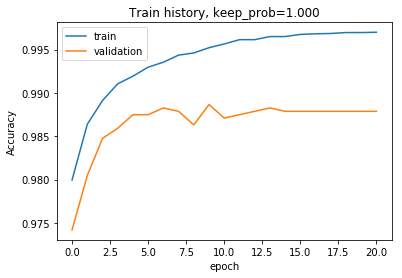

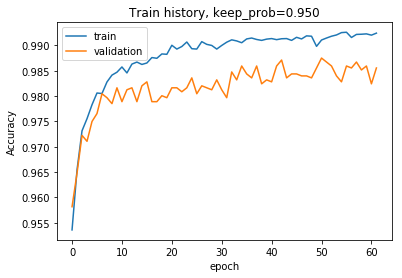

In [31]:
show_train_history(t1, v1, 1.00)
show_train_history(t2, v2, 0.95)

In [32]:
%save MNIST_dropout.py 1-7 18 19 27 30 31

The following commands were written to file `MNIST_dropout.py`:

import time
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from functools import partial
from keras.utils.np_utils import to_categorical
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST_data/")
X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]
y_train1 = to_categorical(y_train1, num_classes=5)
y_valid1 = to_categorical(y_valid1, num_classes=5)
y_test1 = to_categorical(y_test1, num_classes=5)
def init_input():
    with tf.name_scope('input'):
        X = tf.placeholder('float', [None, 784], name='input_x')
        y = tf.placeholder('float', [None, 